Para la realización del examen global se usará el lenguaje de programación Python 3.8.8 junto con las librerías:


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

`cv2` es el nombre de la librería de OpenCV, la cual contiene métodos para el procesamiento de imágenes digitales. `numpy` es una librería matemática que facilita las operaciones que se pueden realizar con OpenCV. `matplotlib` nos permite visualizar los resultados al manipular imágenes.

# Delimitación de rueda y detección de ejes

El primer paso será leer la imagen de la rueda. Usaremos un variable para guardar el objeto de la imagen una vez leída, para poder así referenciarla cuando queramos detectar el círculo y los ejes.

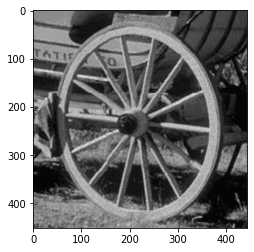

In [2]:
img = cv2.imread('rueda.png')
plt.imshow(img);

Para contar las líneas primero le aplicaremos el algoritmo de detección de bordes del operador Canny a la imagen de la rueda. El umbral inferior de 200 y el superior de 400 fueron seleccionados para que los bordes de las líneas siguieran siendo detectados más no el resto de los bordes de la imagen, siendo el último argumento el tamaño del operador Sobel.

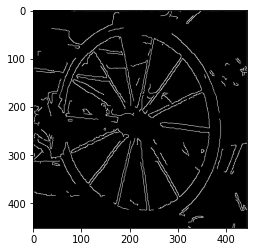

In [3]:
edges = cv2.Canny(img, 200, 400, 3)
plt.imshow(edges, 'gray');

Habiendo detectado los bordes y asegurándonos de que los bordes de los ejes de las ruedas son visibles, pasaremos a usar una función que implementa la transformada de Hough para la detección de líneas en una imagen. Los parámetros $\rho$ y $\theta$ son valores comúnes, mientras que el umbral es 115 para no tomar en cuenta los bordes tenues que alcanzaron a ser detectados, ni los muy marcados al fondo. La longitud mínima de línea es 50 y la distancia máxima entre puntos de una línea es 5, debido al tamaño aparente de los ejes.

In [4]:
import math

lines = cv2.HoughLinesP(edges, 1, math.pi / 180, 115, 50, 5)
len(lines)

14

El resultado de la transformada de Hough fue totalmente acertado al contar 14 líneas, correspondientes a los 14 ejes que podemos ver en la imagen.

Ahora pasaremos a identificar la forma circular de la rueda usando de nuevo la transformada de Hough pero para formas circulares. Sin embargo, antes de eso, le aplicaremos una serie de filtros a la imagen para eliminar el ruido extra y poder obtener una detección más precisa.

Después, procederemos a definir los parámetros para la transformada de Hough. Primeramente usaremos el gradiente de Hough, el cual dentro de la librería OpenCV es un constante. La proporción inversa del acumulador es 2, los parámetros específicos son iguales en 10, y el mínimo y máximo del radio se dejan en 0 para que no haya restricciones. Con estos parámetros aplicamos la transformada para detectar formas circulares. Luego mediante un ciclo, usaremos estos resultados convertidos en enteros para dibujarlos sobre la imagen, cuya forma final será el círculo detectado de la rueda en rojo, y su centro en verde.

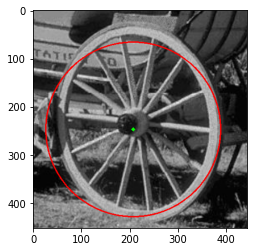

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 5)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
gray = cv2.medianBlur(gray, 5)
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 2, 1000, param1=10, param2=10, minRadius=0, maxRadius=0)
for c in np.uint16(np.around(circles))[0, :]:
    a = c[0]
    b = c[1]
    r = c[2]
    cv2.circle(img, (a, b), r, (255, 0, 0), 2)
    cv2.circle(img, (a, b), 2, (0, 255, 0), 3)
plt.imshow(img, 'gray');

El círculo detectado no fue exactamente igual a la forma de la rueda, pero es bastante acertado, y el centro del círculo está muy cerca del centro de la rueda.

# Detección de rostro y líneas

Al comenzar, igual que en el programa anterior, empezaremos por leer la imagen de la cebra para poder detectar su cabeza y contar las líneas negras.

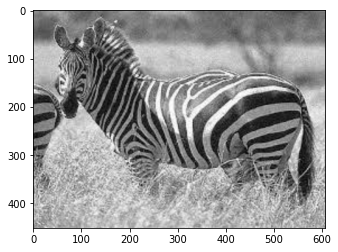

In [6]:
img = cv2.imread('cebra.png')
plt.imshow(img);

Para contar las líneas negras de la imagen, primero aplicaremos un algoritmo de detección de bordes, igual que con la rueda, pero esta vez usaremos diferentes parámetros pues las matices de la imagen son diferentes.

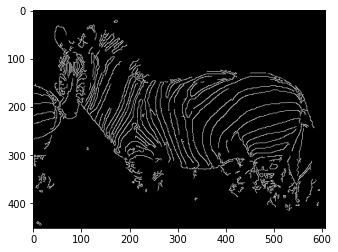

In [7]:
edges = cv2.Canny(img, 200, 500, 3)
plt.imshow(edges, 'gray');

También le aplicaremos la transformada de Hough para detectar líneas, pero con distintos parámetros. Ahora no definiremos una longitud mínima de las líneas debido a que son de diferentes tamaños, y el umbral será algo menor que con la rueda, siendo 90.

In [8]:
lines = cv2.HoughLinesP(edges, 1, math.pi / 180, 90, 0, 4)
len(lines)

27

Intenté contar las líneas negras de la cebra varias veces y llegué a contar entre 20 y 30, ya que en algunas zonas del cuerpo no estoy seguro donde empieza una y termina la otra. El algoritmo nos devolvió 27, por lo que podemos decir que es preciso.

Ahora, para pintar las rayas negras de la cebra de morado, usaremos la librería _Pillow_, la cual ofrece métodos para el procesamiento de imágenes al igual que OpenCV, pero facilita la manipulación de los pixeles de una imagen mediante un arreglo.

In [18]:
from PIL import Image

pimg = Image.open('cebra.png')
array = np.array(pimg)
array[:1]

array([[[131, 131, 131, 255],
        [128, 128, 128, 255],
        [130, 130, 130, 255],
        ...,
        [135, 135, 135, 255],
        [133, 133, 133, 255],
        [132, 132, 132, 255]]], dtype=uint8)

Vamos a definir el color que queremos buscar para reemplazar (negro en este caso) y el nuevo color que lo sustituirá (morado), ambos en formato RGB.

In [10]:
black = (0, 0, 0)
purple = (255, 79, 214)

Descompondremos el arreglo de la imagen en rojo, verde y azul, los tres colores RGB que después usaremos en operaciones con bits para sustituir cada pixel negro por uno morado, luego usando un método de la librería Pillow crearemos una imagen a partir de este arreglo modificado.

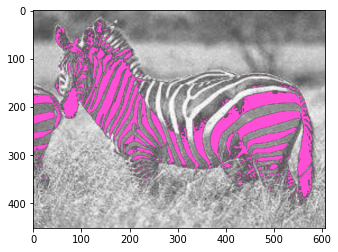

In [11]:
r = array[:, :, 0]
g = array[:, :, 1]
b = array[:, :, 2]
mask = (r <= black[0] + 75) & (g <= black[1] + 75) & (b <= black[2] + 75)
array[:, :, :3][mask] = purple

plt.imshow(Image.fromarray(array));

El siguiente ejercicio de este programa sería detectar el rostro de la cebra; sin embargo, después de una investigación para realizar este proceso me di cuenta que sería necesario entrenar una red convolusional con un conjunto de datos de imágenes de cebras para que aprendiera los patrones de sus rostros. Para simplificar el proceso, en el ejercicio se detectará el contorno de la cebra completa.

Debido a que la imagen presenta mucho ruido, el primer paso será eliminarlo mediante un filtro gaussiano, cuyo tamaño del _kernel_ será de $35 \times 35$ y la desviación estándar 3. Las dimensiones del _kernel_ se deben a que intentamos eliminar lo más que podamos la diferencia de contraste de las rayas negras.

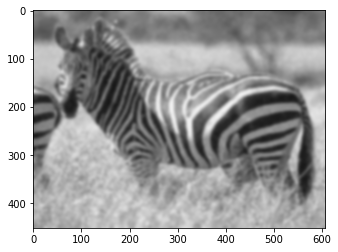

In [12]:
img = cv2.GaussianBlur(img, (35, 35), 3)
plt.imshow(img);

Para poder detectar los contornos primero convertiremos la imagen a formato en escala de grises, ya que es el nivel al que operan las funciones que usarmeos a continuación. Luego le aplicaremos una función de umbral a cada elemento del arreglo de la imagen, cuyo valor será 150 con un máximo de 255. Después pasaremos a usar la función para encontrar los contornos en la imagen umbralizada, con el modo "recuperación en árbol", el cual recupera todos los contornos y los reconstruye en una jerarquía de contornos anidados, y el método de aproximación "simple en cadena", que comprime los segmentos en todas direcciones dejando solamente los puntos finales. Finalmente dibujaremos todos los contornos detectados en color amarillo.

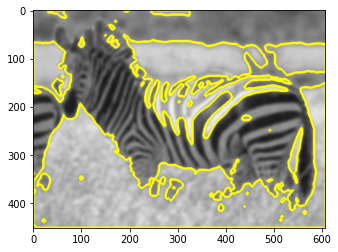

In [13]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 150, 255, 0)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (255, 255, 0), 4)
plt.imshow(img);

Podemos notar que las rayas negras de la cebra fueron detectadas como contornos. Esto se debe a la alta diferencia de contraste entre el cuerpo blanco de la cebra y las rayas negras, la cual para el programa de visión computacional significa un contorno de la figura. Sin embargo, como se mencionó anteriormente, gracias al ruido gaussiano aplicado no todas las líneas fueron tomadas como contornos.